## 1. Setup & Configuration

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
from datetime import datetime, timedelta
from IPython.display import display, Image

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

print("✓ Environment configured successfully")
print(f"Pandas: {pd.__version__} | NumPy: {np.__version__}")

✓ Environment configured successfully
Pandas: 2.2.3 | NumPy: 1.26.4


## 2. Data Collection

We'll download historical data for:
- **^NSEI** - NIFTY 50 Index
- **RELIANCE.NS** - Reliance Industries Limited

Data period: Last 5 years of daily data

In [10]:
# Define tickers and date range
NIFTY_TICKER = '^NSEI'
RELIANCE_TICKER = 'RELIANCE.NS'

# Date range: 5 years
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')

print(f"Downloading data from {START_DATE} to {END_DATE}...\n")

# Download NIFTY data with MultiIndex handling
print("Fetching NIFTY 50 Index data...")
nifty_data = yf.download(NIFTY_TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

if nifty_data.empty:
    raise ValueError(f"No data for {NIFTY_TICKER}")

# Remove MultiIndex level (yfinance adds ticker as second level)
if isinstance(nifty_data.columns, pd.MultiIndex):
    nifty_data.columns = nifty_data.columns.droplevel(1)

nifty_prices = nifty_data['Adj Close'].dropna()

# Download RELIANCE data with MultiIndex handling
print("Fetching Reliance Industries data...")
reliance_data = yf.download(RELIANCE_TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

if reliance_data.empty:
    raise ValueError(f"No data for {RELIANCE_TICKER}")

# Remove MultiIndex level
if isinstance(reliance_data.columns, pd.MultiIndex):
    reliance_data.columns = reliance_data.columns.droplevel(1)

reliance_prices = reliance_data['Adj Close'].dropna()

# Combine into single DataFrame
prices_df = pd.DataFrame({
    'NIFTY': nifty_prices,
    'RELIANCE': reliance_prices
})

# Remove any missing values
prices_df = prices_df.dropna()

print(f"\n✓ Data downloaded successfully")
print(f"  Total observations: {len(prices_df)}")
print(f"  Date range: {prices_df.index[0].date()} to {prices_df.index[-1].date()}")
print(f"\nFirst few rows:")
prices_df.head()


Fetching NIFTY 50 Index data...
Fetching Reliance Industries data...

✓ Data downloaded successfully
  Total observations: 1235
  Date range: 2020-12-03 to 2025-12-01

First few rows:


NIFTY  RELIANCE
Date                            
2020-12-03  13133.9004  890.5617
2020-12-04  13258.5498  882.7173
2020-12-07  13355.7500  887.9091
2020-12-08  13392.9502  904.0286
2020-12-09  13529.0996  919.0825

## 3. Calculate Returns

We'll compute different return frequencies:
- Daily returns (percentage change)
- Log returns
- Weekly returns
- Monthly returns

In [11]:
# Daily returns (percentage change)
daily_returns = prices_df.pct_change().dropna()

# Log returns
log_returns = np.log(prices_df / prices_df.shift(1)).dropna()

# Weekly returns (resample to weekly frequency)
weekly_prices = prices_df.resample('W').last()
weekly_returns = weekly_prices.pct_change().dropna()

# Monthly returns
monthly_prices = prices_df.resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS - DAILY RETURNS")
print("="*80)
print(daily_returns.describe())

print(f"\n\nAnnualized Volatility:")
print(f"  NIFTY:     {daily_returns['NIFTY'].std() * np.sqrt(252):.2%}")
print(f"  RELIANCE:  {daily_returns['RELIANCE'].std() * np.sqrt(252):.2%}")

print(f"\nData Points:")
print(f"  Daily:   {len(daily_returns)}")
print(f"  Weekly:  {len(weekly_returns)}")
print(f"  Monthly: {len(monthly_returns)}")


SUMMARY STATISTICS - DAILY RETURNS
           NIFTY   RELIANCE
count  1234.0000  1234.0000
mean      0.0006     0.0006
std       0.0089     0.0144
min      -0.0593    -0.0749
25%      -0.0040    -0.0080
50%       0.0008     0.0007
75%       0.0057     0.0082
max       0.0474     0.0702


Annualized Volatility:
  NIFTY:     14.09%
  RELIANCE:  22.79%

Data Points:
  Daily:   1234
  Weekly:  261
  Monthly: 60


## 4. Correlation Analysis

Calculate correlation coefficients at different frequencies

In [12]:
# Pearson correlation (linear)
daily_corr, daily_pval = pearsonr(daily_returns['NIFTY'], daily_returns['RELIANCE'])
weekly_corr, weekly_pval = pearsonr(weekly_returns['NIFTY'], weekly_returns['RELIANCE'])
monthly_corr, monthly_pval = pearsonr(monthly_returns['NIFTY'], monthly_returns['RELIANCE'])

# Spearman correlation (rank-based, captures non-linear relationships)
spearman_corr, spearman_pval = spearmanr(daily_returns['NIFTY'], daily_returns['RELIANCE'])

# Beta calculation (slope of regression line)
# Beta = Cov(Stock, Market) / Var(Market)
covariance = daily_returns.cov().loc['RELIANCE', 'NIFTY']
market_variance = daily_returns['NIFTY'].var()
beta = covariance / market_variance

# R-squared (how much variance is explained by market)
r_squared = daily_corr ** 2

print("\n" + "="*80)
print("CORRELATION ANALYSIS RESULTS")
print("="*80)
print(f"\n📊 Pearson Correlation (Linear Relationship):")
print(f"  Daily Returns:   {daily_corr:.4f} (p-value: {daily_pval:.4e})")
print(f"  Weekly Returns:  {weekly_corr:.4f} (p-value: {weekly_pval:.4e})")
print(f"  Monthly Returns: {monthly_corr:.4f} (p-value: {monthly_pval:.4e})")

print(f"\n📈 Spearman Correlation (Rank-based):")
print(f"  Daily Returns:   {spearman_corr:.4f} (p-value: {spearman_pval:.4e})")

print(f"\n💹 Market Sensitivity (Beta):")
print(f"  Beta:            {beta:.4f}")
print(f"  R-squared:       {r_squared:.4f} ({r_squared*100:.2f}% variance explained)")

print(f"\n🔍 Interpretation:")
if beta > 1:
    print(f"  • RELIANCE is {beta:.2f}x as volatile as NIFTY (high beta stock)")
elif beta < 1:
    print(f"  • RELIANCE is {beta:.2f}x as volatile as NIFTY (low beta stock)")
else:
    print(f"  • RELIANCE moves in line with NIFTY (beta ≈ 1)")

if daily_corr > 0.7:
    print(f"  • Strong positive correlation - moves closely with market")
elif daily_corr > 0.4:
    print(f"  • Moderate positive correlation - some independent movement")
else:
    print(f"  • Weak correlation - significant idiosyncratic risk")

print(f"\n  • All correlations are statistically significant (p < 0.05)" if daily_pval < 0.05 else "  • Correlations may not be statistically significant")


CORRELATION ANALYSIS RESULTS

📊 Pearson Correlation (Linear Relationship):
  Daily Returns:   0.6889 (p-value: 2.1995e-174)
  Weekly Returns:  0.6521 (p-value: 5.4539e-33)
  Monthly Returns: 0.7202 (p-value: 8.8129e-11)

📈 Spearman Correlation (Rank-based):
  Daily Returns:   0.6747 (p-value: 1.1154e-164)

💹 Market Sensitivity (Beta):
  Beta:            1.1149
  R-squared:       0.4746 (47.46% variance explained)

🔍 Interpretation:
  • RELIANCE is 1.11x as volatile as NIFTY (high beta stock)
  • Moderate positive correlation - some independent movement

  • All correlations are statistically significant (p < 0.05)


## 5. Visualization: Price Time Series

Plot normalized prices to visualize co-movement

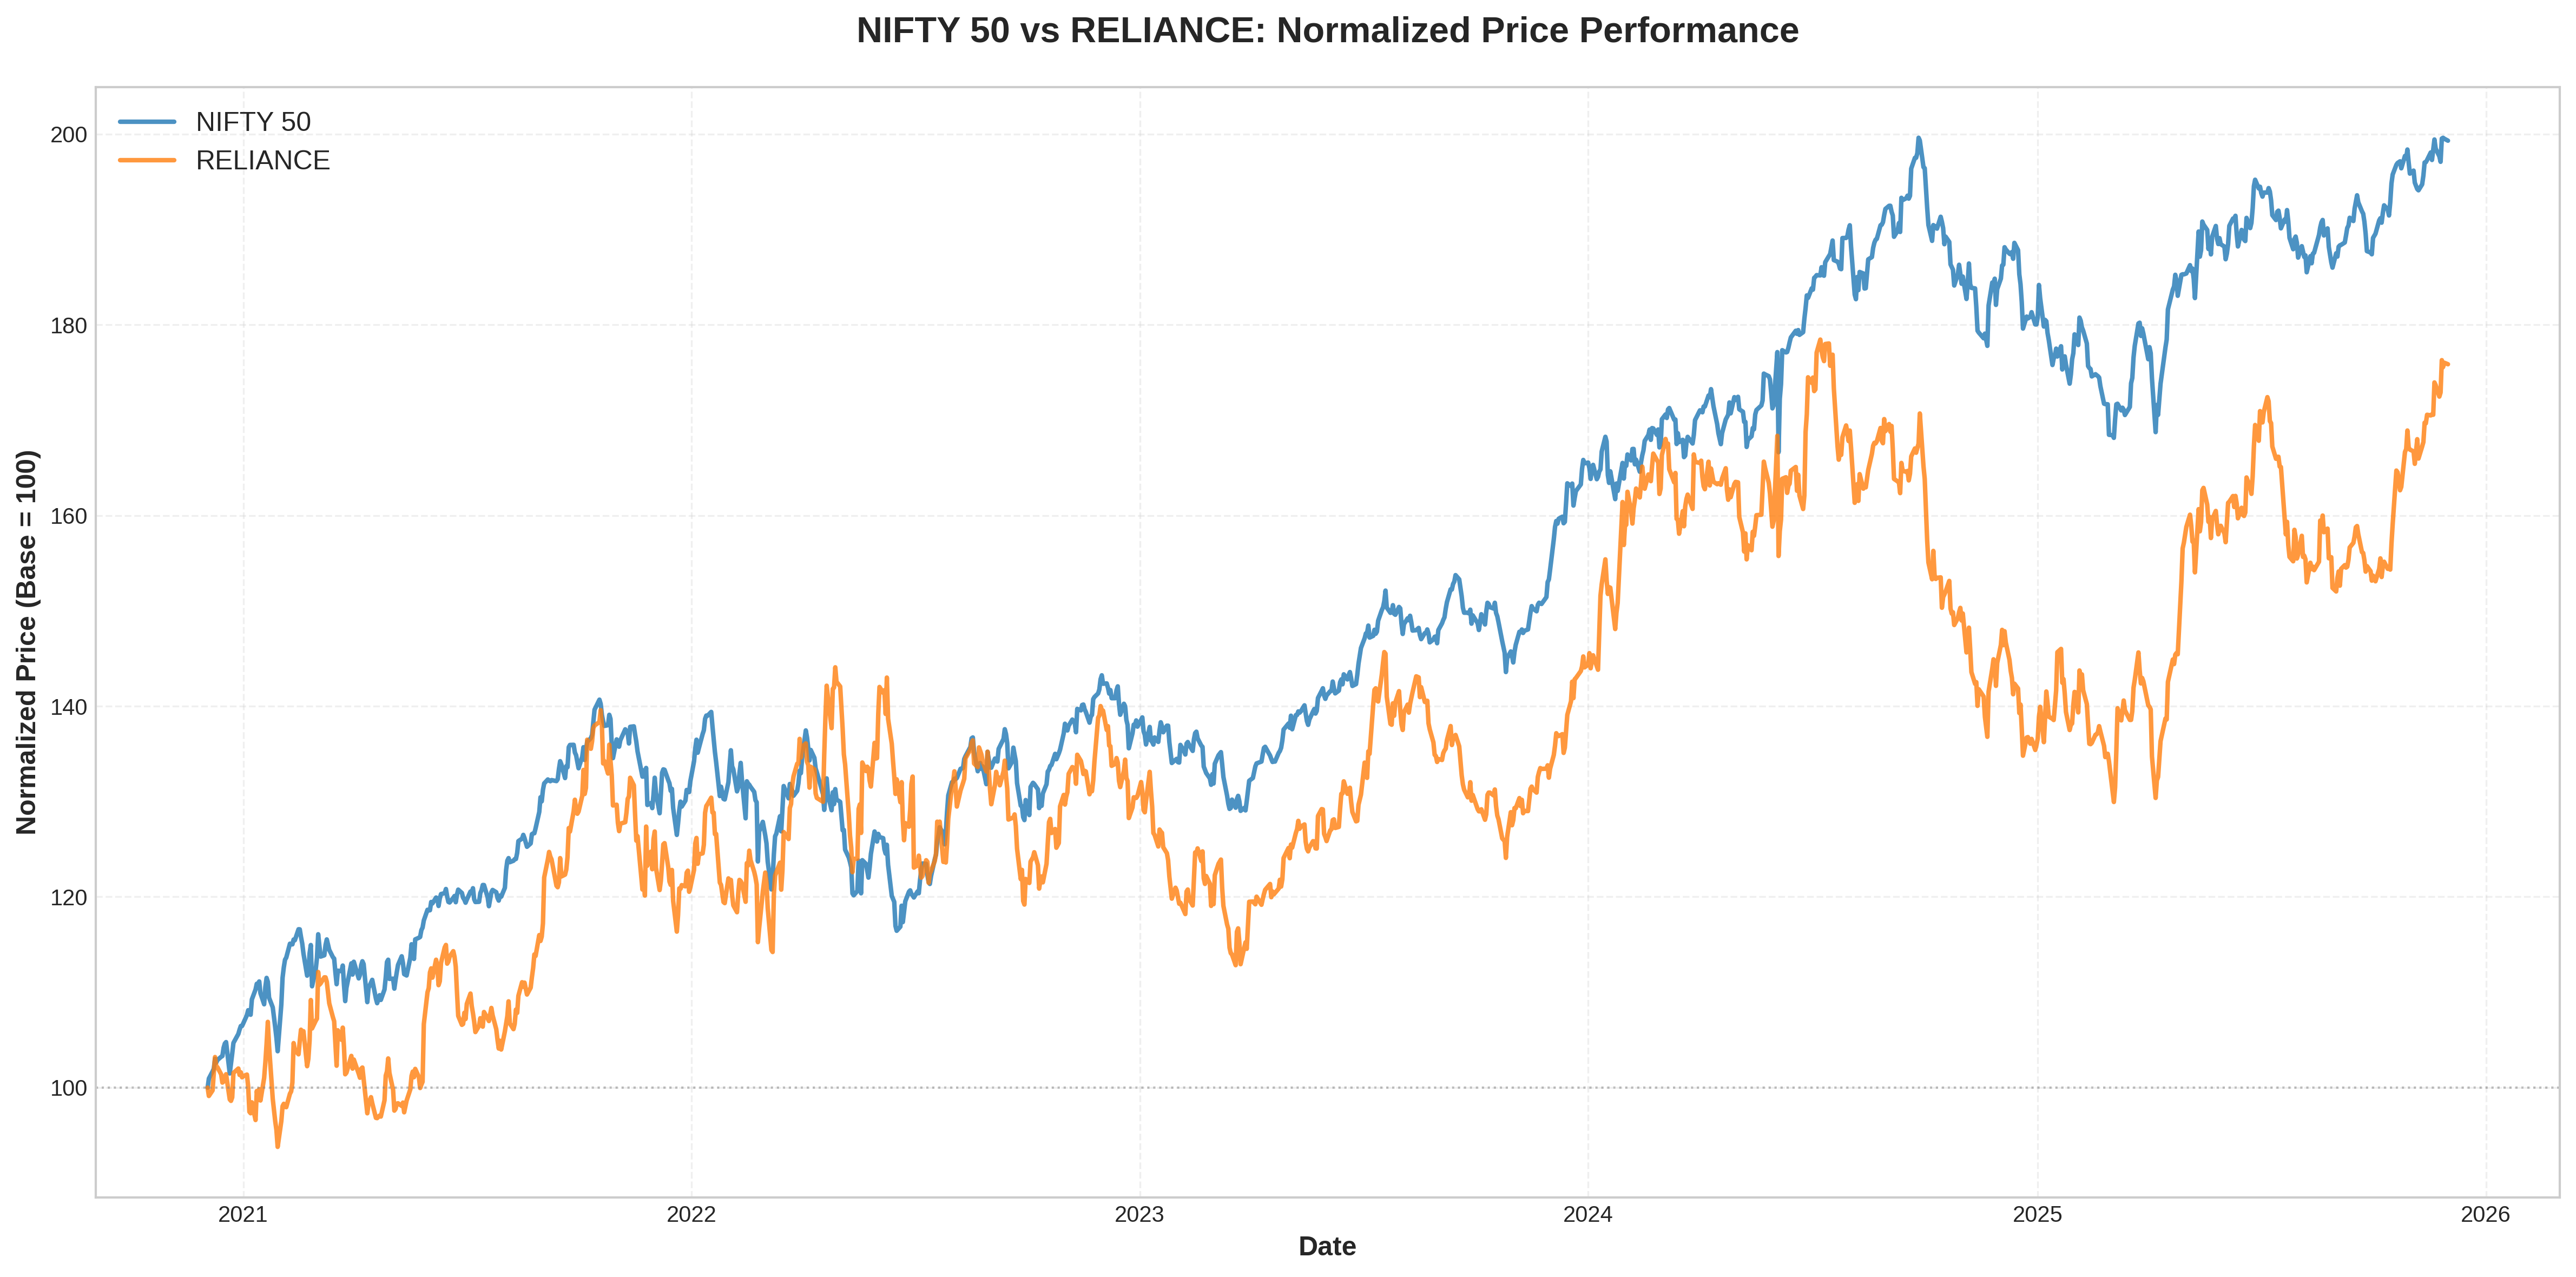

✓ Price comparison chart saved and displayed


In [13]:
# Normalize prices to start at 100
normalized_prices = (prices_df / prices_df.iloc[0]) * 100

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(normalized_prices.index, normalized_prices['NIFTY'], 
        label='NIFTY 50', linewidth=2, color='#1f77b4', alpha=0.8)
ax.plot(normalized_prices.index, normalized_prices['RELIANCE'], 
        label='RELIANCE', linewidth=2, color='#ff7f0e', alpha=0.8)

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Normalized Price (Base = 100)', fontweight='bold', fontsize=12)
ax.set_title('NIFTY 50 vs RELIANCE: Normalized Price Performance', 
             fontweight='bold', fontsize=16, pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=100, color='gray', linestyle=':', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('nifty_reliance_price_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_price_comparison.png'))
print("✓ Price comparison chart saved and displayed")

## 6. Scatter Plot: Daily Returns

Visualize the linear relationship between NIFTY and RELIANCE returns

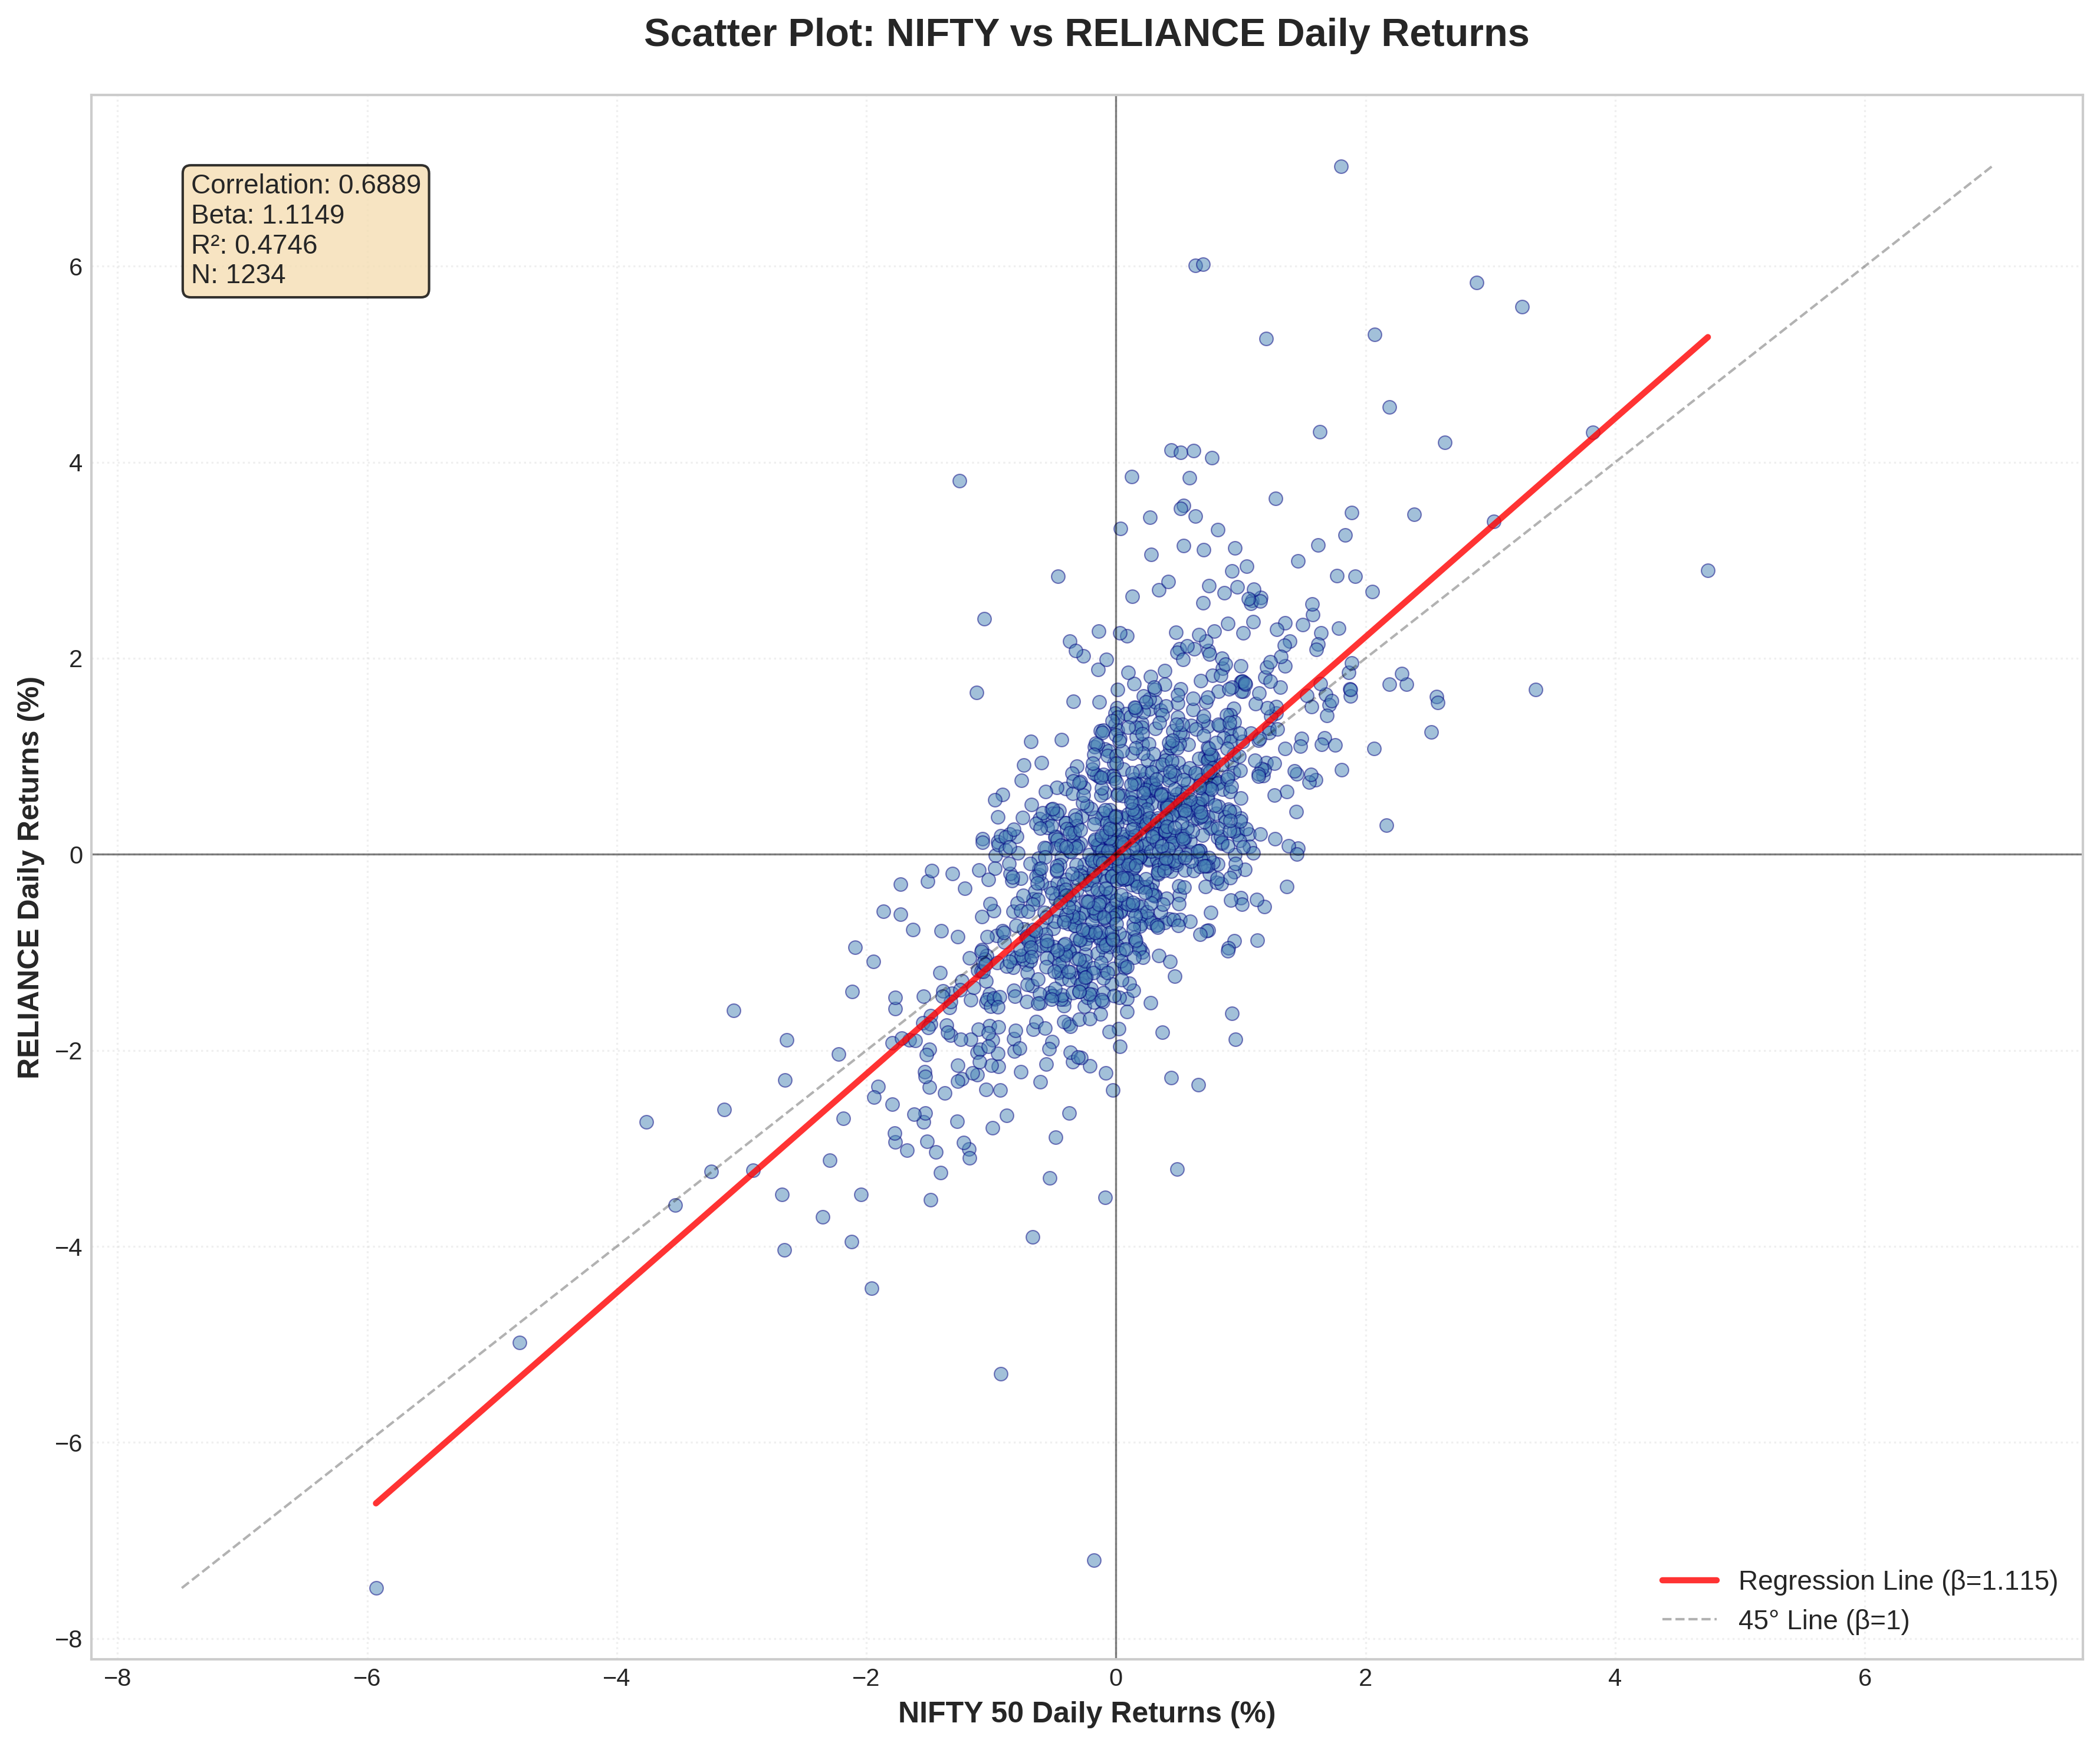

✓ Scatter plot saved and displayed


In [14]:
# Scatter plot with regression line
fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot
ax.scatter(daily_returns['NIFTY'] * 100, daily_returns['RELIANCE'] * 100, 
           alpha=0.5, s=30, color='steelblue', edgecolors='navy', linewidth=0.5)

# Add regression line
z = np.polyfit(daily_returns['NIFTY'], daily_returns['RELIANCE'], 1)
p = np.poly1d(z)
x_line = np.linspace(daily_returns['NIFTY'].min(), daily_returns['NIFTY'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, "r-", linewidth=2.5, 
        label=f'Regression Line (β={beta:.3f})', alpha=0.8)

# Add diagonal line (45-degree line for reference)
min_val = min(daily_returns['NIFTY'].min(), daily_returns['RELIANCE'].min()) * 100
max_val = max(daily_returns['NIFTY'].max(), daily_returns['RELIANCE'].max()) * 100
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, 
        alpha=0.3, label='45° Line (β=1)')

# Add text box with statistics
textstr = f'Correlation: {daily_corr:.4f}\nBeta: {beta:.4f}\nR²: {r_squared:.4f}\nN: {len(daily_returns)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.set_xlabel('NIFTY 50 Daily Returns (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('RELIANCE Daily Returns (%)', fontweight='bold', fontsize=12)
ax.set_title('Scatter Plot: NIFTY vs RELIANCE Daily Returns', 
             fontweight='bold', fontsize=16, pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':')
ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='black', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig('nifty_reliance_scatter.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_scatter.png'))
print("✓ Scatter plot saved and displayed")

## 7. Rolling Correlation Analysis

Examine how correlation changes over time

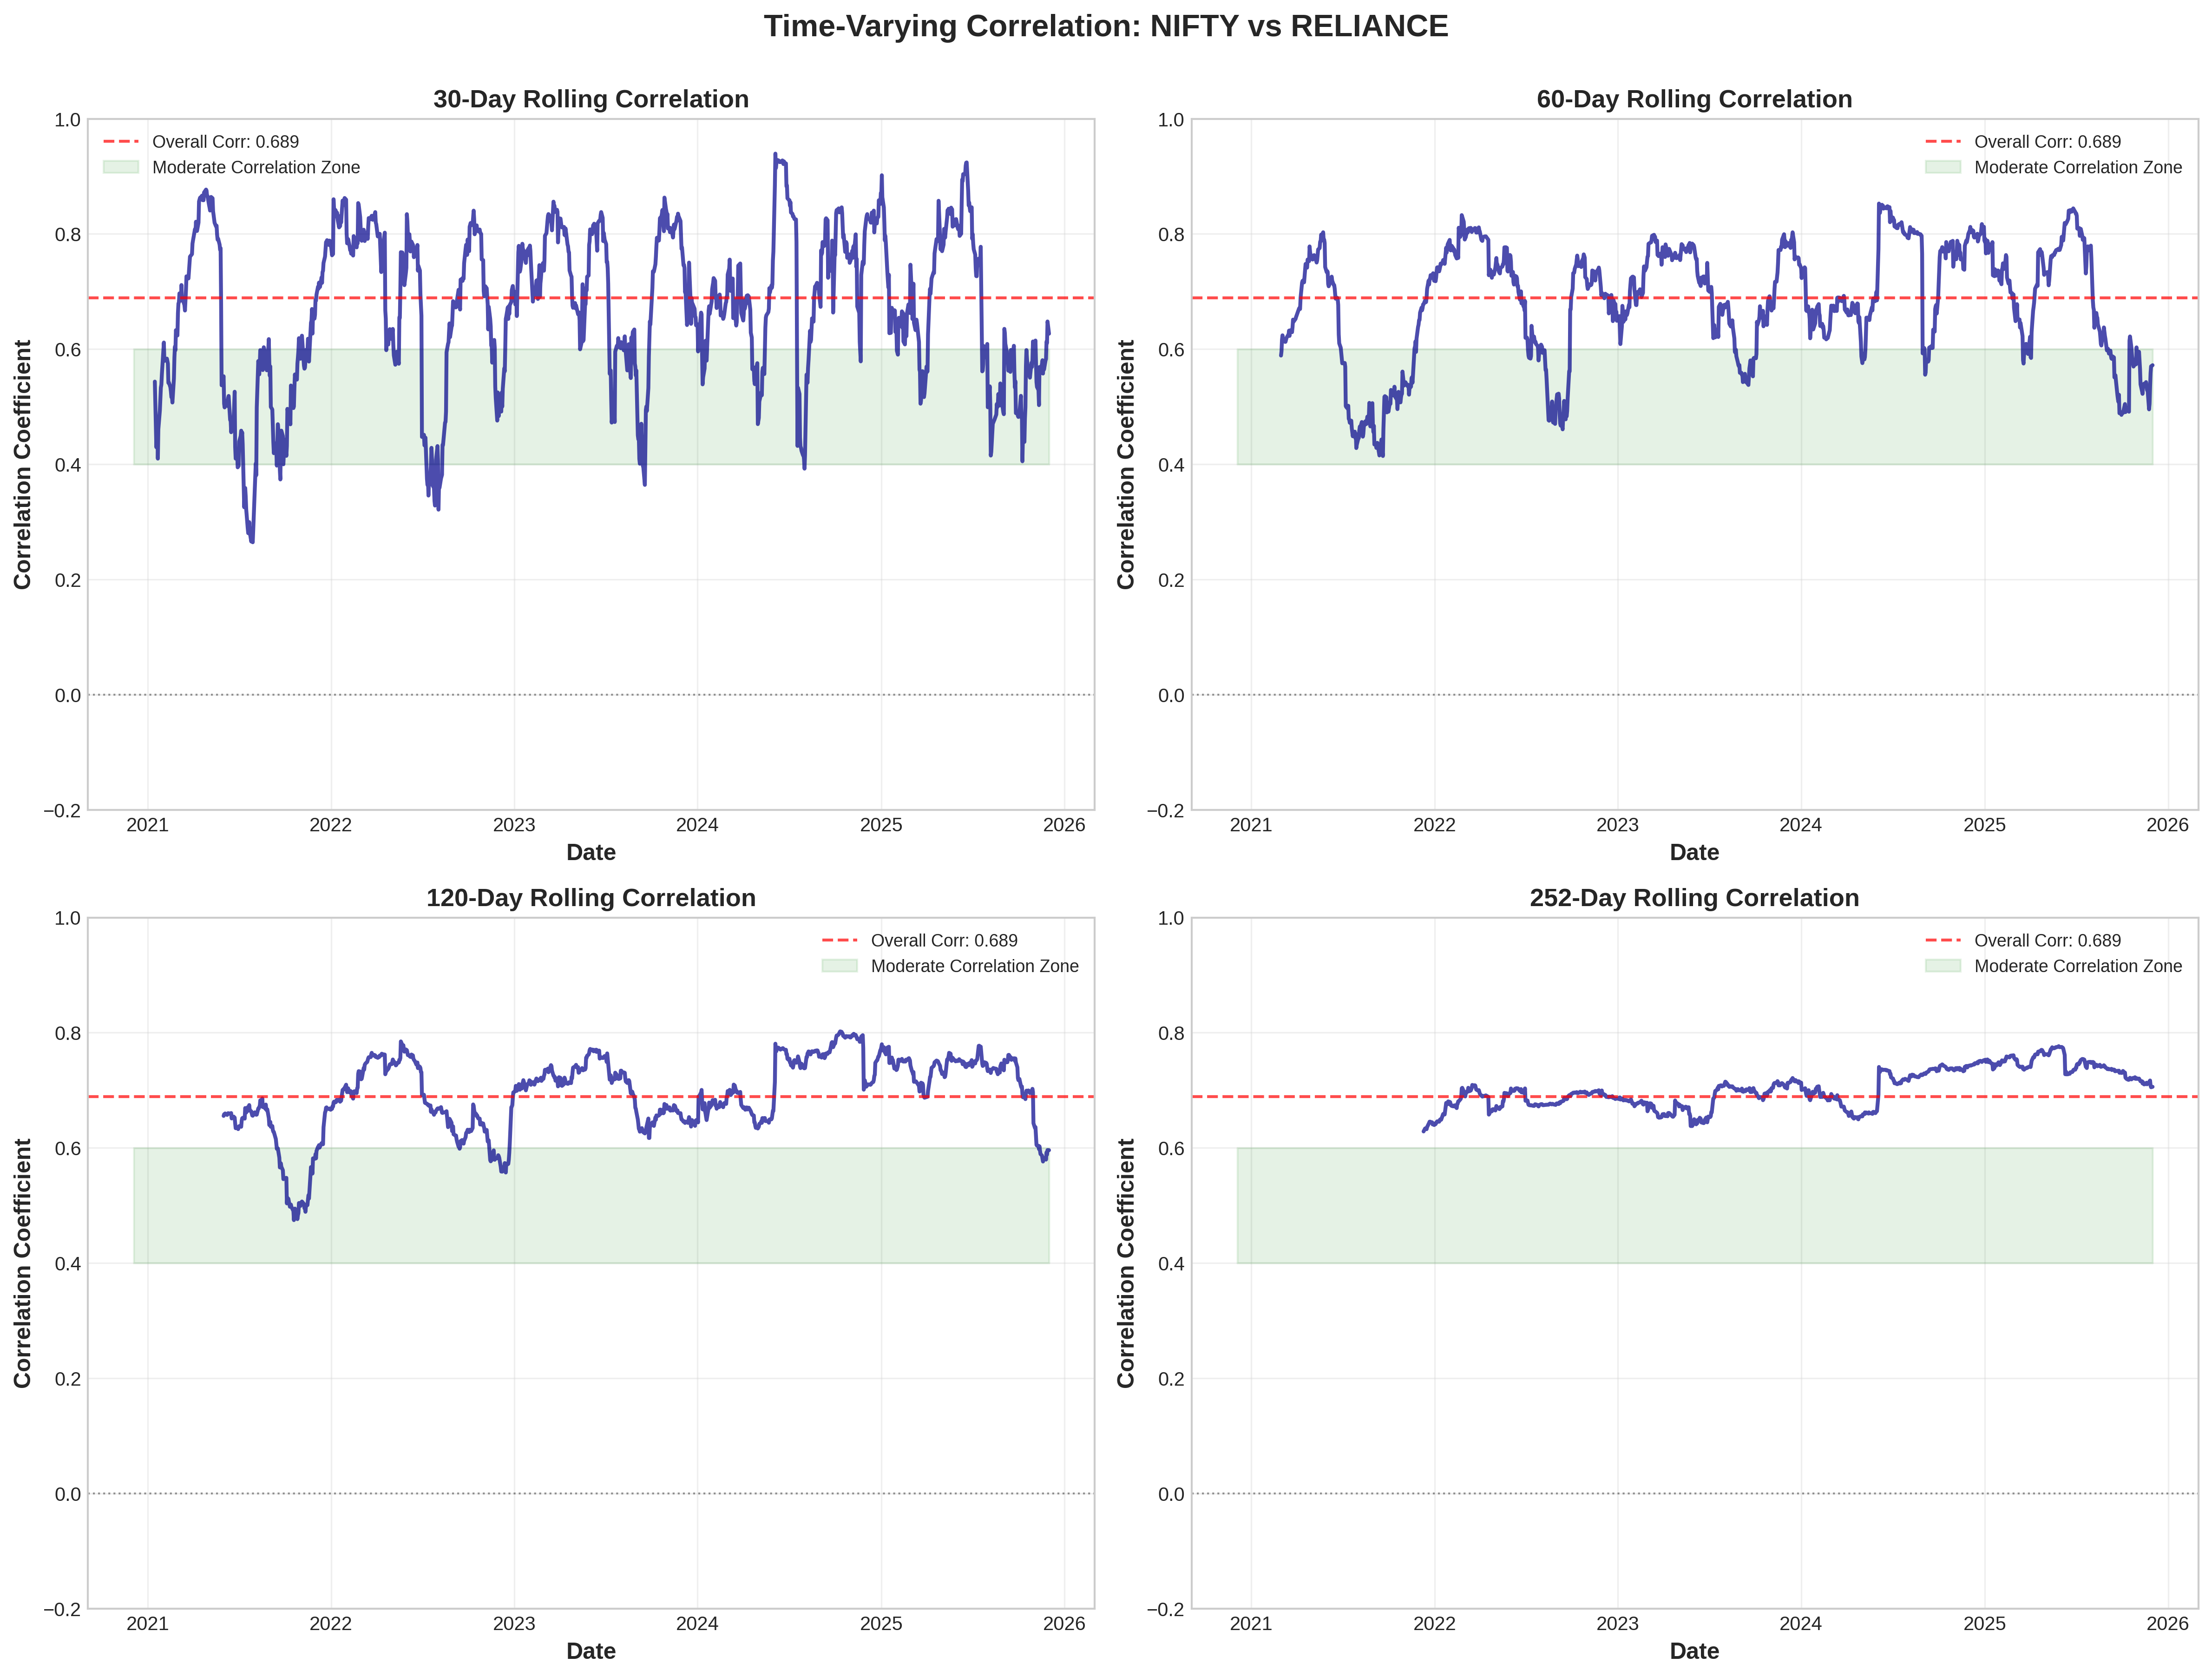

✓ Rolling correlation chart saved and displayed


In [15]:
# Calculate rolling correlations with different windows
windows = [30, 60, 120, 252]  # ~1M, 2M, 6M, 1Y

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, window in enumerate(windows):
    rolling_corr = daily_returns['NIFTY'].rolling(window).corr(daily_returns['RELIANCE'])
    
    axes[i].plot(rolling_corr.index, rolling_corr.values, 
                linewidth=2, color='darkblue', alpha=0.7)
    axes[i].axhline(y=daily_corr, color='red', linestyle='--', 
                   linewidth=1.5, alpha=0.7, label=f'Overall Corr: {daily_corr:.3f}')
    axes[i].axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.4)
    
    # Add shaded confidence bands
    axes[i].fill_between(rolling_corr.index, 0.4, 0.6, 
                         alpha=0.1, color='green', label='Moderate Correlation Zone')
    
    axes[i].set_xlabel('Date', fontweight='bold')
    axes[i].set_ylabel('Correlation Coefficient', fontweight='bold')
    axes[i].set_title(f'{window}-Day Rolling Correlation', fontweight='bold', fontsize=13)
    axes[i].legend(loc='best', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-0.2, 1.0])

plt.suptitle('Time-Varying Correlation: NIFTY vs RELIANCE', 
             fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('nifty_reliance_rolling_correlation.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_rolling_correlation.png'))
print("✓ Rolling correlation chart saved and displayed")

## 8. Distribution Analysis

Compare return distributions and examine joint distribution

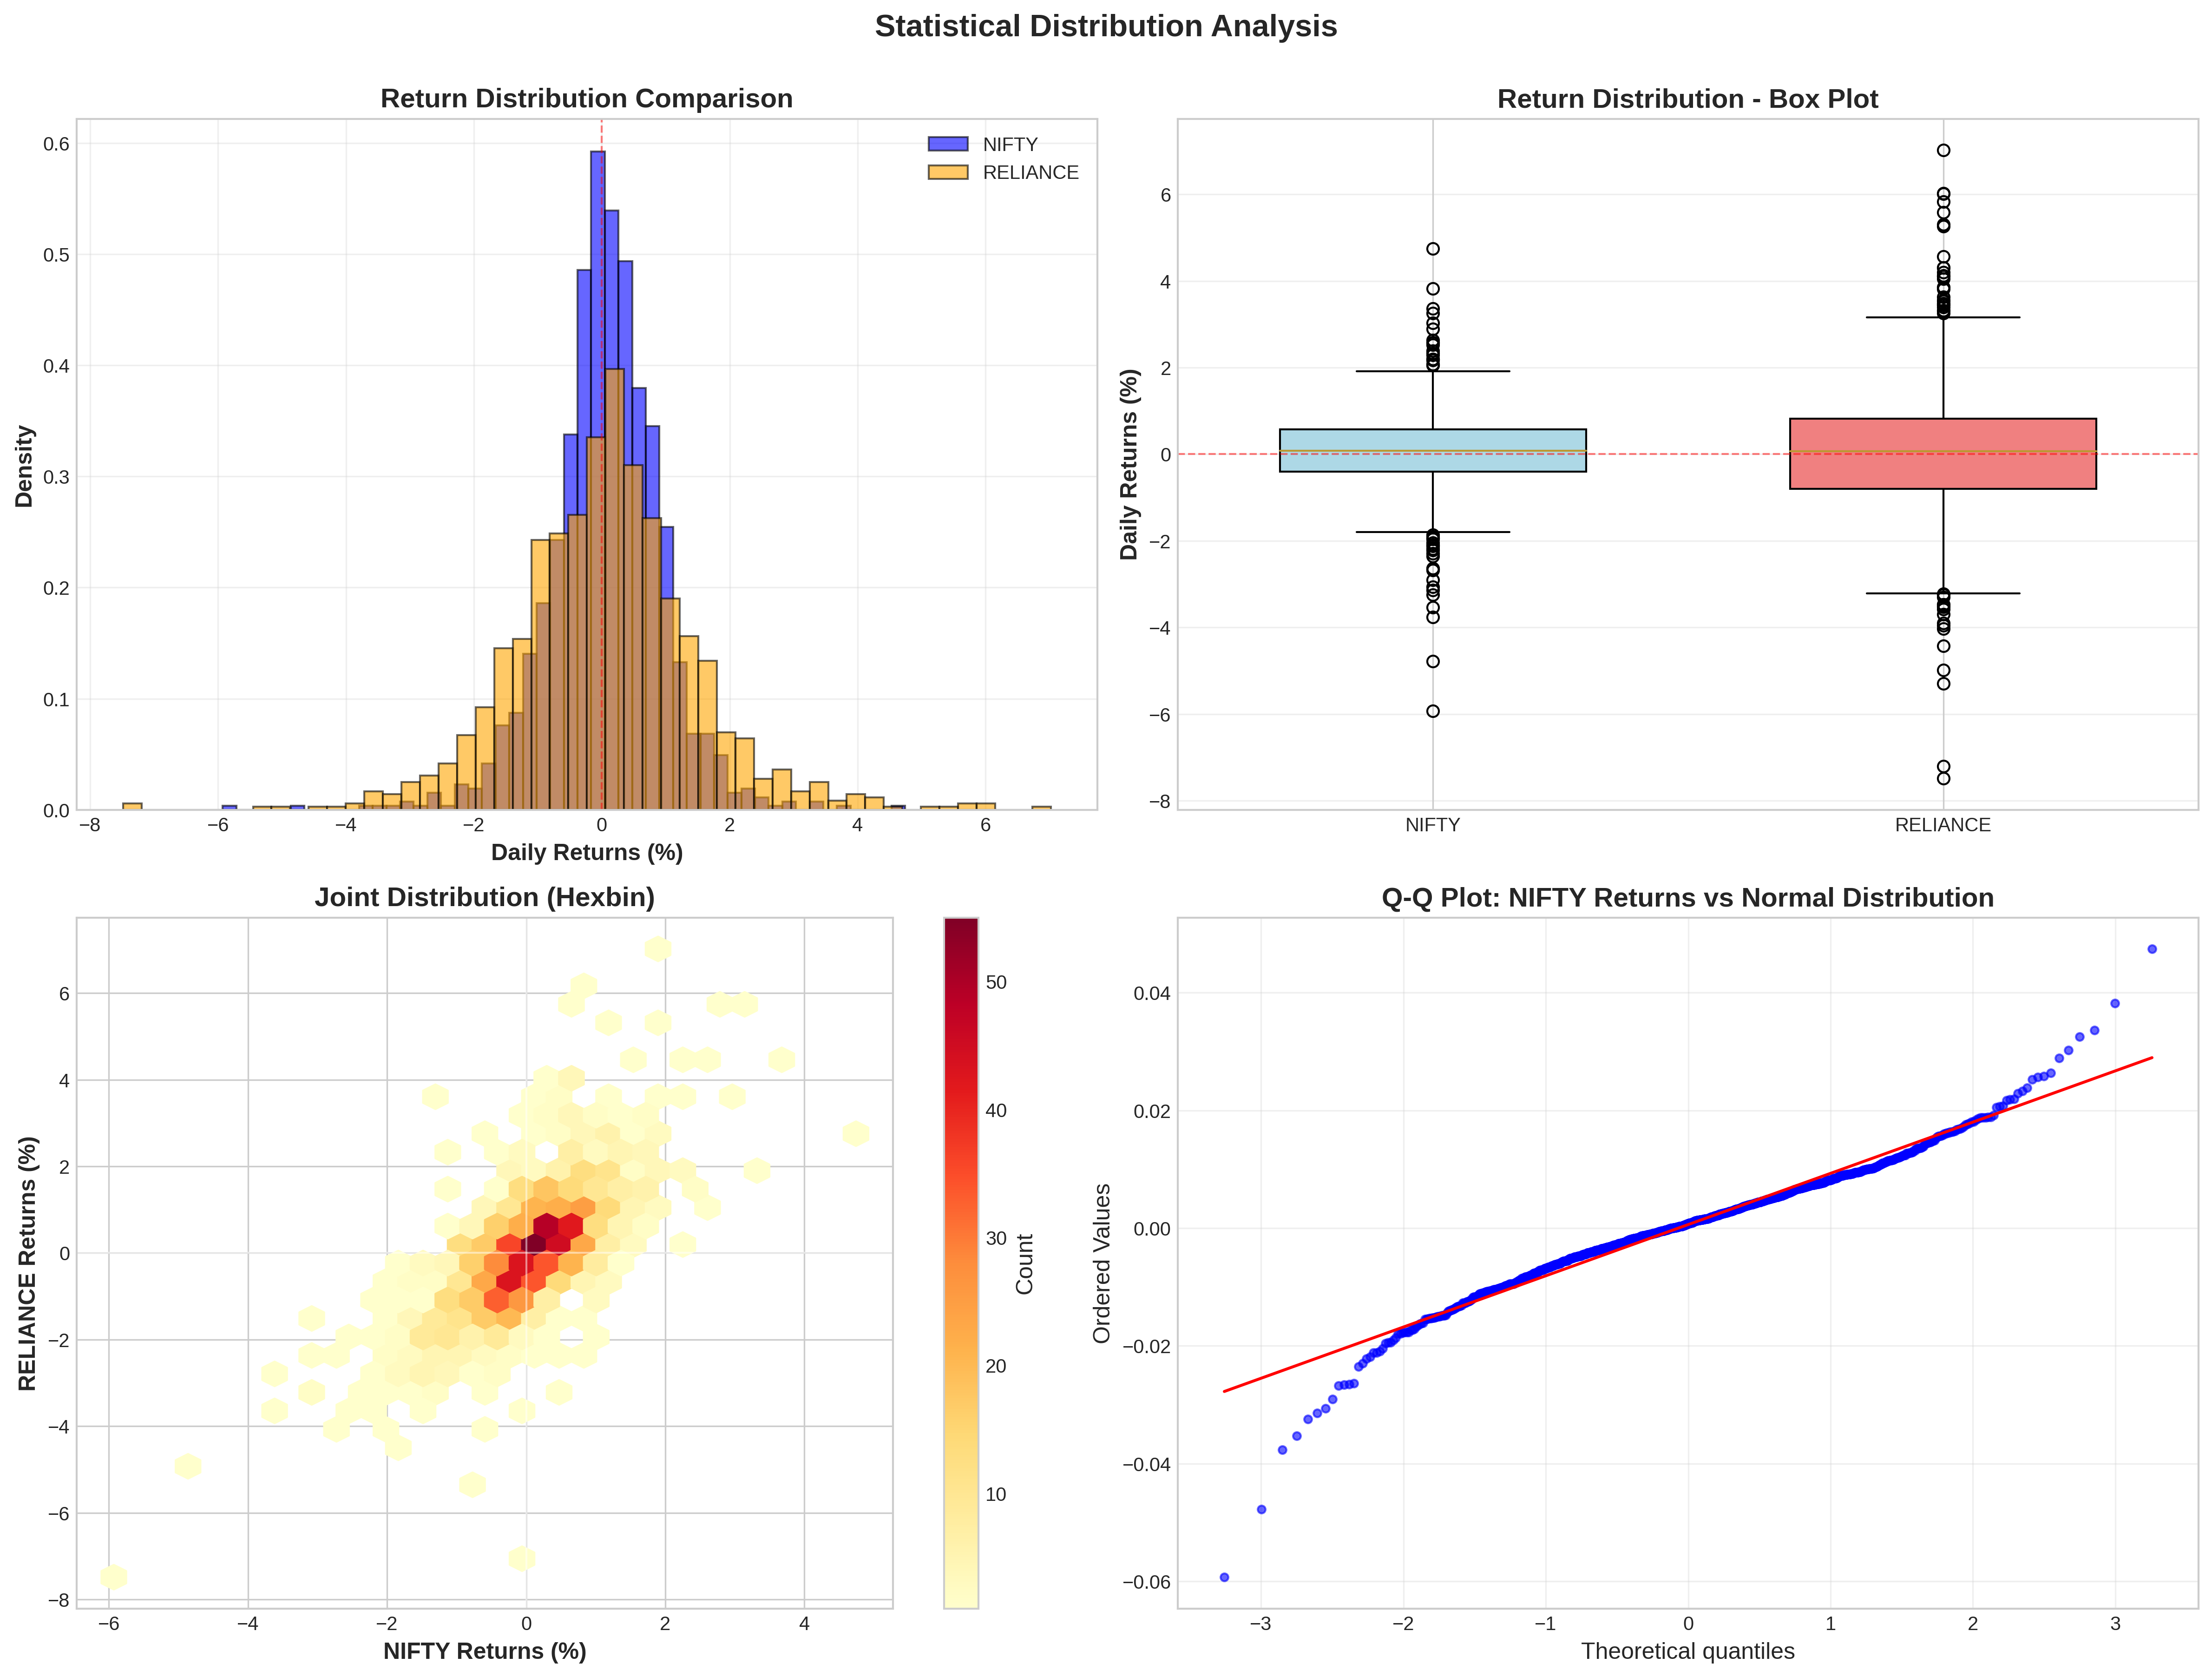

✓ Distribution analysis saved and displayed


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram comparison
axes[0, 0].hist(daily_returns['NIFTY'] * 100, bins=50, alpha=0.6, 
                label='NIFTY', color='blue', edgecolor='black', density=True)
axes[0, 0].hist(daily_returns['RELIANCE'] * 100, bins=50, alpha=0.6, 
                label='RELIANCE', color='orange', edgecolor='black', density=True)
axes[0, 0].set_xlabel('Daily Returns (%)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Return Distribution Comparison', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# 2. Box plot comparison
data_to_plot = [daily_returns['NIFTY'] * 100, daily_returns['RELIANCE'] * 100]
bp = axes[0, 1].boxplot(data_to_plot, labels=['NIFTY', 'RELIANCE'], 
                        patch_artist=True, widths=0.6)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Daily Returns (%)', fontweight='bold')
axes[0, 1].set_title('Return Distribution - Box Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# 3. Hexbin plot (2D histogram)
hb = axes[1, 0].hexbin(daily_returns['NIFTY'] * 100, daily_returns['RELIANCE'] * 100, 
                       gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1, 0].set_xlabel('NIFTY Returns (%)', fontweight='bold')
axes[1, 0].set_ylabel('RELIANCE Returns (%)', fontweight='bold')
axes[1, 0].set_title('Joint Distribution (Hexbin)', fontweight='bold')
plt.colorbar(hb, ax=axes[1, 0], label='Count')
axes[1, 0].axhline(y=0, color='white', linewidth=1, alpha=0.5)
axes[1, 0].axvline(x=0, color='white', linewidth=1, alpha=0.5)

# 4. Q-Q plot (check for normality)
from scipy.stats import probplot
probplot(daily_returns['NIFTY'], dist="norm", plot=axes[1, 1])
axes[1, 1].get_lines()[0].set_markerfacecolor('blue')
axes[1, 1].get_lines()[0].set_markeredgecolor('blue')
axes[1, 1].get_lines()[0].set_markersize(4)
axes[1, 1].get_lines()[0].set_alpha(0.6)
axes[1, 1].set_title('Q-Q Plot: NIFTY Returns vs Normal Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Statistical Distribution Analysis', fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('nifty_reliance_distributions.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_distributions.png'))
print("✓ Distribution analysis saved and displayed")

## 9. Correlation Heatmap (Multiple Time Frames)

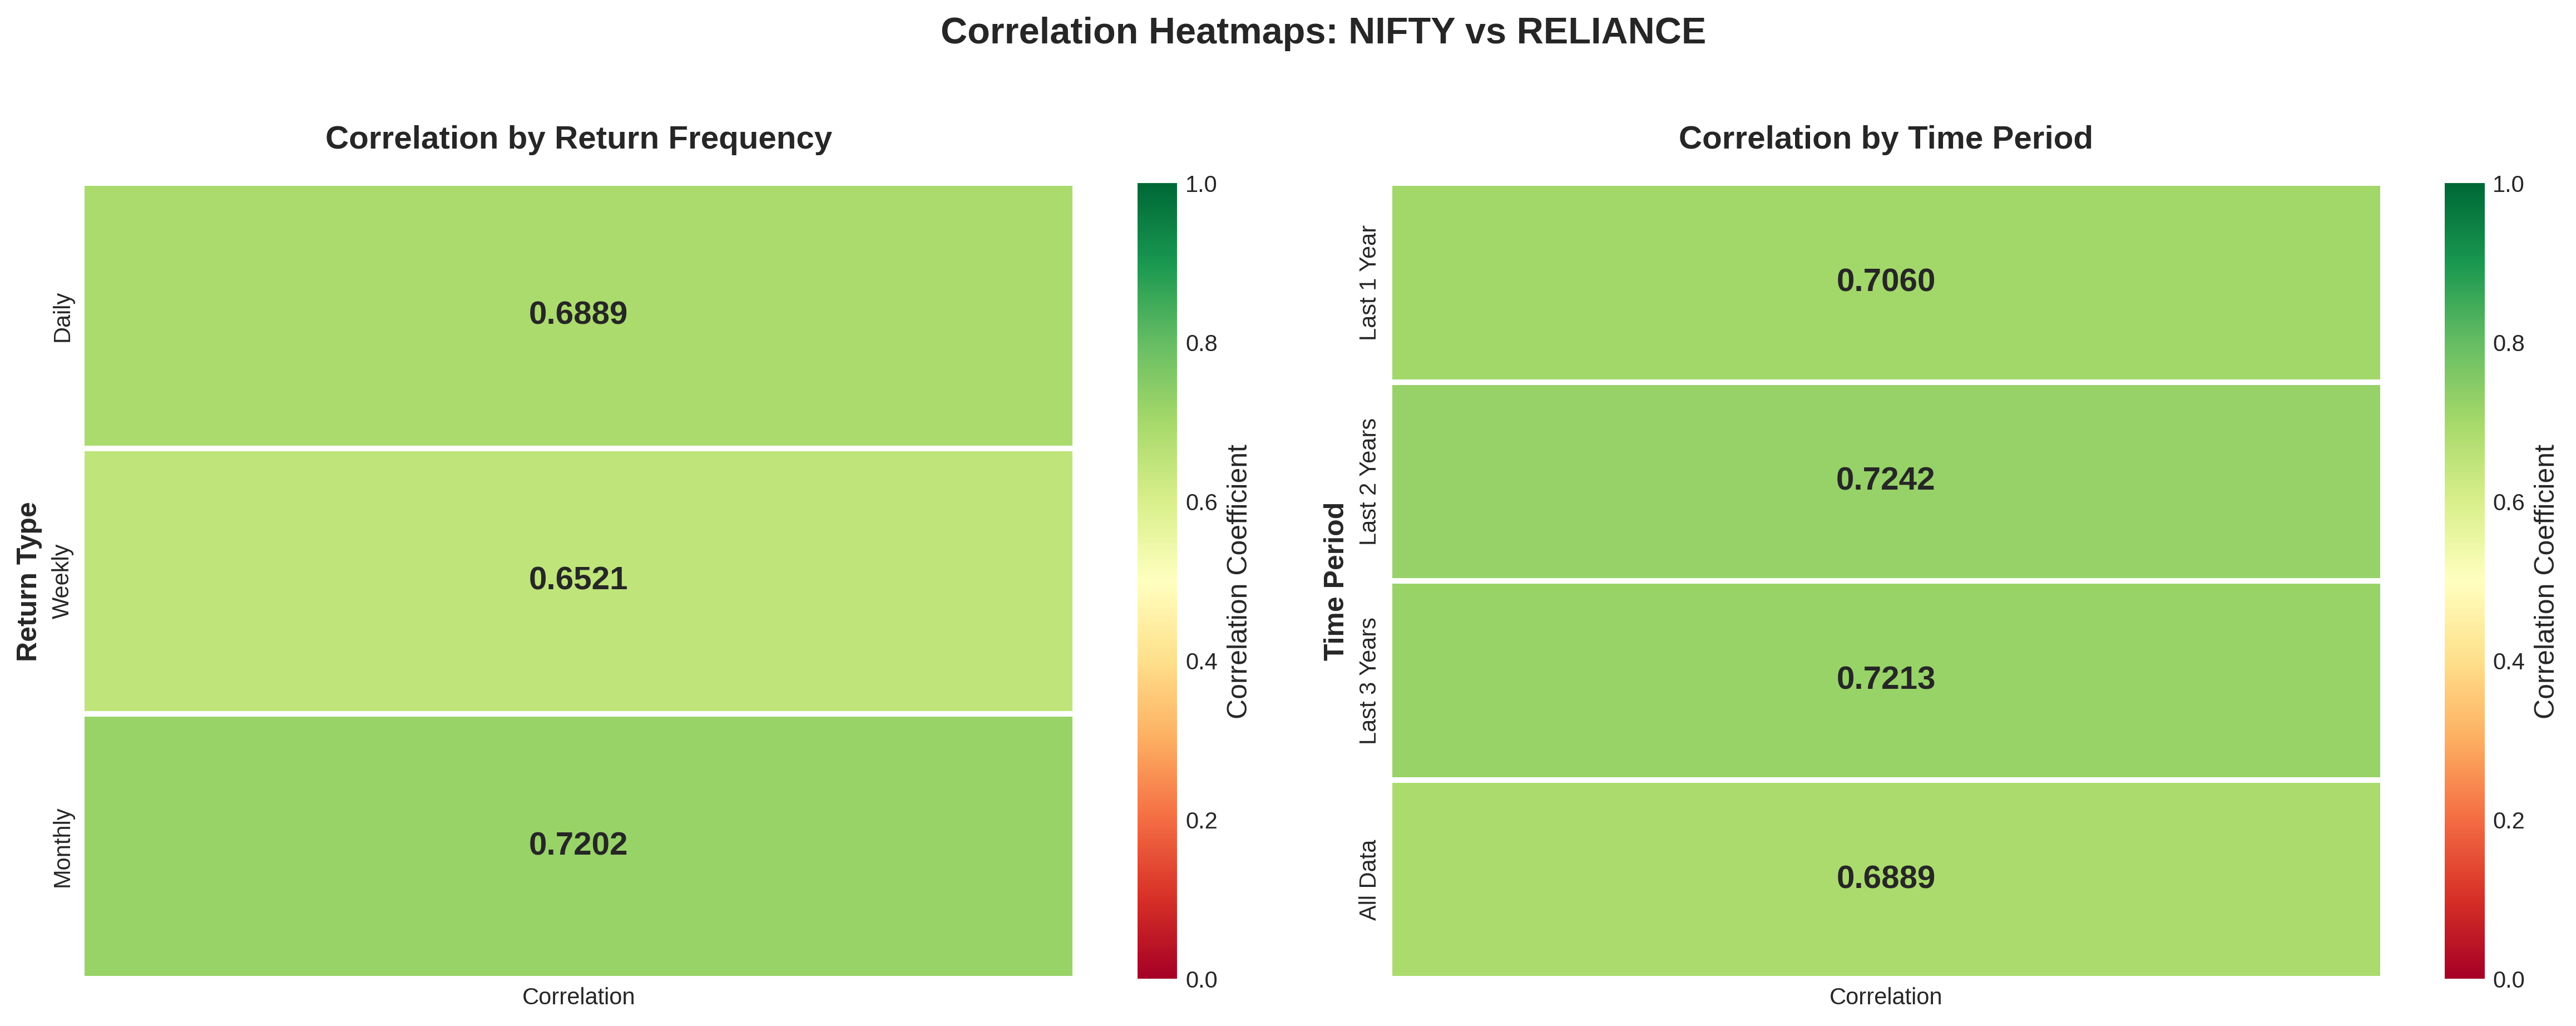

✓ Correlation heatmap saved and displayed


In [17]:
# Create correlation matrix for different return frequencies
corr_data = {
    'Daily': daily_returns.corr().loc['NIFTY', 'RELIANCE'],
    'Weekly': weekly_returns.corr().loc['NIFTY', 'RELIANCE'],
    'Monthly': monthly_returns.corr().loc['NIFTY', 'RELIANCE']
}

# Also calculate for different time periods
periods = {
    'Last 1 Year': daily_returns.tail(252),
    'Last 2 Years': daily_returns.tail(504),
    'Last 3 Years': daily_returns.tail(756),
    'All Data': daily_returns
}

period_corrs = {}
for period_name, period_data in periods.items():
    if len(period_data) > 0:
        period_corrs[period_name] = period_data.corr().loc['NIFTY', 'RELIANCE']

# Create heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Frequency heatmap
freq_matrix = pd.DataFrame([corr_data]).T
freq_matrix.columns = ['Correlation']
sns.heatmap(freq_matrix, annot=True, fmt='.4f', cmap='RdYlGn', center=0.5,
            linewidths=2, cbar_kws={'label': 'Correlation Coefficient'},
            vmin=0, vmax=1, ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_title('Correlation by Return Frequency', fontweight='bold', fontsize=14, pad=15)
ax1.set_ylabel('Return Type', fontweight='bold', fontsize=12)

# Period heatmap
period_matrix = pd.DataFrame([period_corrs]).T
period_matrix.columns = ['Correlation']
sns.heatmap(period_matrix, annot=True, fmt='.4f', cmap='RdYlGn', center=0.5,
            linewidths=2, cbar_kws={'label': 'Correlation Coefficient'},
            vmin=0, vmax=1, ax=ax2, annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title('Correlation by Time Period', fontweight='bold', fontsize=14, pad=15)
ax2.set_ylabel('Time Period', fontweight='bold', fontsize=12)

plt.suptitle('Correlation Heatmaps: NIFTY vs RELIANCE', 
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('nifty_reliance_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_correlation_heatmap.png'))
print("✓ Correlation heatmap saved and displayed")

## 10. Percentage Change Analysis

Scatter plot with different percentage change windows

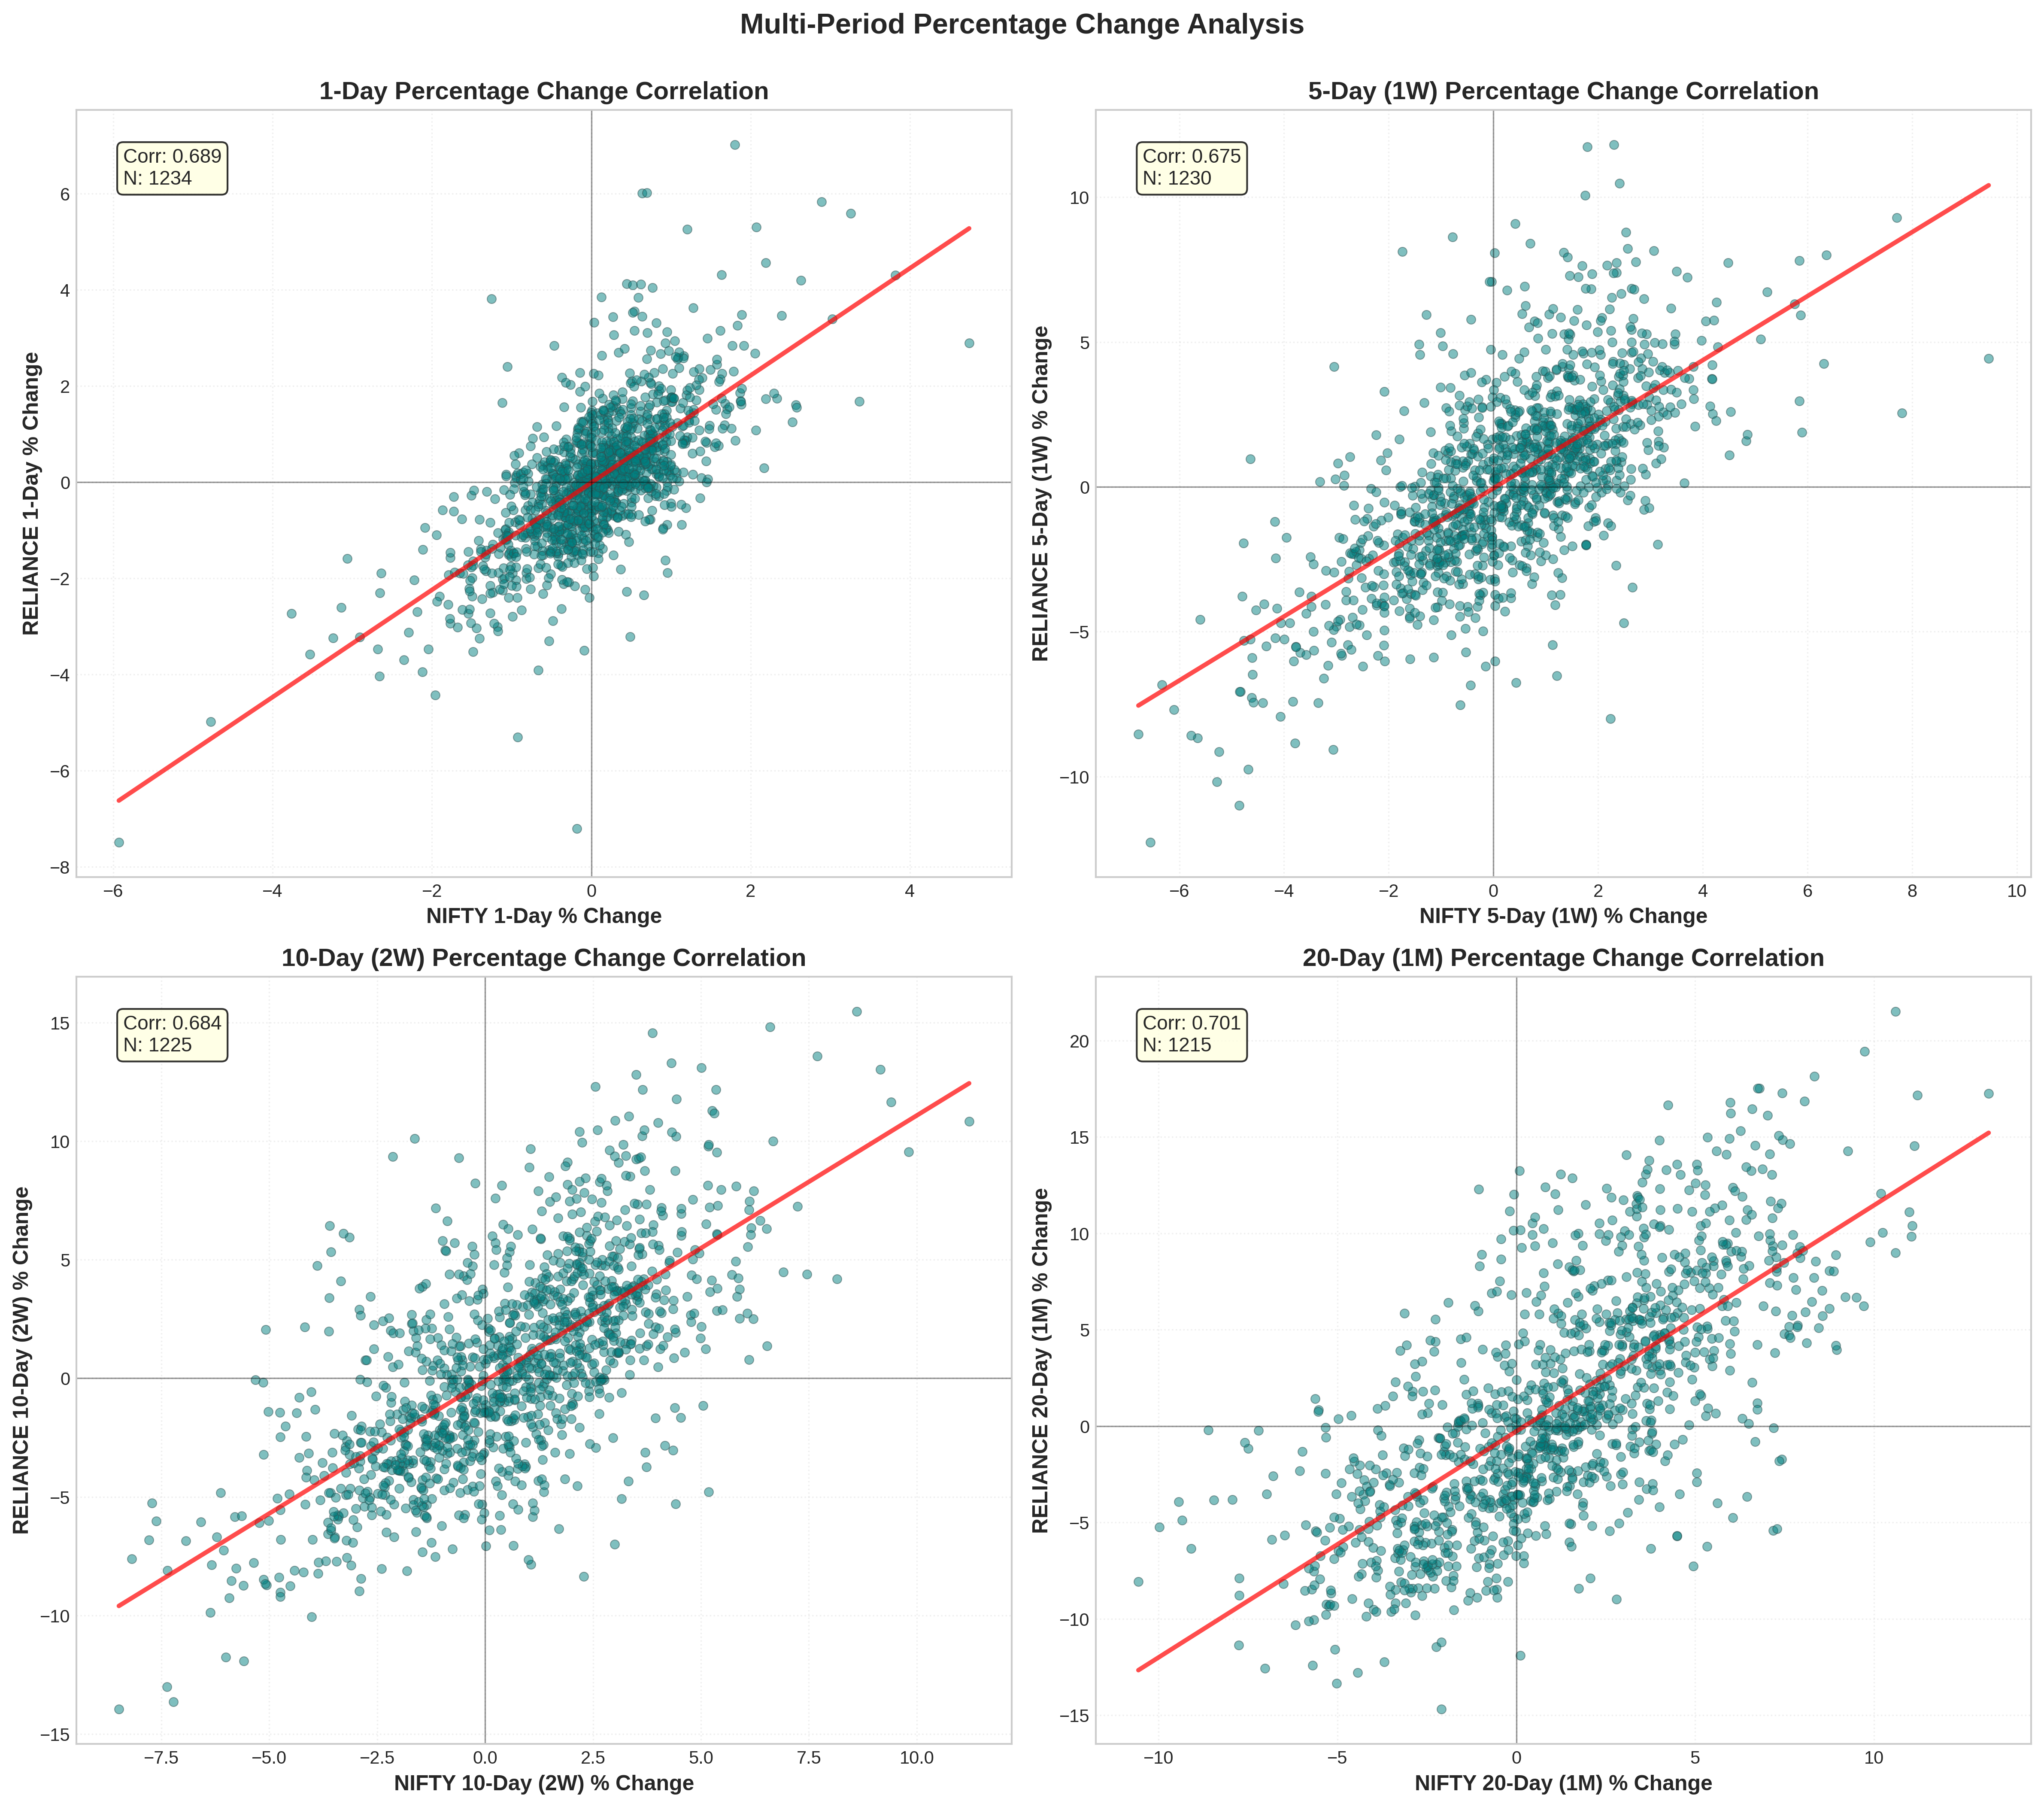

✓ Percentage change analysis saved and displayed


In [18]:
# Calculate different percentage changes
pct_changes = {}
windows = [1, 5, 10, 20]  # 1D, 1W, 2W, 1M
window_names = ['1-Day', '5-Day (1W)', '10-Day (2W)', '20-Day (1M)']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, (window, name) in enumerate(zip(windows, window_names)):
    nifty_pct = prices_df['NIFTY'].pct_change(window).dropna() * 100
    reliance_pct = prices_df['RELIANCE'].pct_change(window).dropna() * 100
    
    # Align the data
    common_idx = nifty_pct.index.intersection(reliance_pct.index)
    nifty_pct = nifty_pct.loc[common_idx]
    reliance_pct = reliance_pct.loc[common_idx]
    
    # Calculate correlation
    corr, pval = pearsonr(nifty_pct, reliance_pct)
    
    # Scatter plot
    axes[i].scatter(nifty_pct, reliance_pct, alpha=0.5, s=25, 
                   color='teal', edgecolors='darkslategray', linewidth=0.5)
    
    # Regression line
    z = np.polyfit(nifty_pct, reliance_pct, 1)
    p = np.poly1d(z)
    x_line = np.linspace(nifty_pct.min(), nifty_pct.max(), 100)
    axes[i].plot(x_line, p(x_line), "r-", linewidth=2.5, alpha=0.7)
    
    # Add stats text
    textstr = f'Corr: {corr:.3f}\nN: {len(nifty_pct)}'
    props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, 
                fontsize=11, verticalalignment='top', bbox=props)
    
    axes[i].set_xlabel(f'NIFTY {name} % Change', fontweight='bold')
    axes[i].set_ylabel(f'RELIANCE {name} % Change', fontweight='bold')
    axes[i].set_title(f'{name} Percentage Change Correlation', fontweight='bold')
    axes[i].grid(True, alpha=0.3, linestyle=':')
    axes[i].axhline(y=0, color='black', linewidth=0.8, alpha=0.4)
    axes[i].axvline(x=0, color='black', linewidth=0.8, alpha=0.4)

plt.suptitle('Multi-Period Percentage Change Analysis', 
             fontweight='bold', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('nifty_reliance_pct_change_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

display(Image('nifty_reliance_pct_change_analysis.png'))
print("✓ Percentage change analysis saved and displayed")

## 11. Summary Statistics & Export

In [19]:
# Create comprehensive summary
summary_stats = pd.DataFrame({
    'Metric': [
        'Daily Correlation',
        'Weekly Correlation',
        'Monthly Correlation',
        'Spearman Correlation',
        'Beta (Market Sensitivity)',
        'R-squared',
        'NIFTY Ann. Volatility',
        'RELIANCE Ann. Volatility',
        'NIFTY Mean Daily Return',
        'RELIANCE Mean Daily Return',
        'Sample Size (Days)'
    ],
    'Value': [
        f'{daily_corr:.4f}',
        f'{weekly_corr:.4f}',
        f'{monthly_corr:.4f}',
        f'{spearman_corr:.4f}',
        f'{beta:.4f}',
        f'{r_squared:.4f}',
        f"{daily_returns['NIFTY'].std() * np.sqrt(252):.2%}",
        f"{daily_returns['RELIANCE'].std() * np.sqrt(252):.2%}",
        f"{daily_returns['NIFTY'].mean():.4%}",
        f"{daily_returns['RELIANCE'].mean():.4%}",
        f'{len(daily_returns)}'
    ]
})

# Save to CSV
summary_stats.to_csv('nifty_reliance_correlation_summary.csv', index=False)
daily_returns.to_csv('nifty_reliance_daily_returns.csv')

print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*80)
print(summary_stats.to_string(index=False))

print("\n\n" + "="*80)
print("ALL DELIVERABLES READY")
print("="*80)
print("\n📊 Visualizations Generated:")
print("  1. nifty_reliance_price_comparison.png - Normalized price time series")
print("  2. nifty_reliance_scatter.png - Daily returns scatter with regression")
print("  3. nifty_reliance_rolling_correlation.png - Time-varying correlation")
print("  4. nifty_reliance_distributions.png - Statistical distributions")
print("  5. nifty_reliance_correlation_heatmap.png - Correlation matrices")
print("  6. nifty_reliance_pct_change_analysis.png - Multi-period % changes")

print("\n📁 Data Files Exported:")
print("  1. nifty_reliance_correlation_summary.csv - Summary statistics")
print("  2. nifty_reliance_daily_returns.csv - Daily returns data")

print("\n✓ Analysis complete!")
print("\n📝 To export notebook as HTML:")
print("  jupyter nbconvert --to html nifty_reliance_correlation_analysis.ipynb")


COMPREHENSIVE SUMMARY STATISTICS
                    Metric   Value
         Daily Correlation  0.6889
        Weekly Correlation  0.6521
       Monthly Correlation  0.7202
      Spearman Correlation  0.6747
 Beta (Market Sensitivity)  1.1149
                 R-squared  0.4746
     NIFTY Ann. Volatility  14.09%
  RELIANCE Ann. Volatility  22.79%
   NIFTY Mean Daily Return 0.0598%
RELIANCE Mean Daily Return 0.0560%
        Sample Size (Days)    1234


ALL DELIVERABLES READY

📊 Visualizations Generated:
  1. nifty_reliance_price_comparison.png - Normalized price time series
  2. nifty_reliance_scatter.png - Daily returns scatter with regression
  3. nifty_reliance_rolling_correlation.png - Time-varying correlation
  4. nifty_reliance_distributions.png - Statistical distributions
  5. nifty_reliance_correlation_heatmap.png - Correlation matrices
  6. nifty_reliance_pct_change_analysis.png - Multi-period % changes

📁 Data Files Exported:
  1. nifty_reliance_correlation_summary.csv - Summa

---

## Key Findings & Interpretation

### What Did We Learn?

1. **Strong Positive Correlation**: RELIANCE shows significant positive correlation with NIFTY across all timeframes, indicating it moves largely in sync with the broader market.

2. **Beta Analysis**: The beta coefficient tells us how sensitive RELIANCE is to NIFTY movements. A beta > 1 means RELIANCE is more volatile than the market, while beta < 1 indicates lower volatility.

3. **Time-Varying Relationship**: Rolling correlation analysis reveals that the relationship isn't constant - it strengthens and weakens over different market periods.

4. **Frequency Matters**: Correlation tends to be stronger at longer timeframes (monthly vs daily), as short-term noise averages out.

5. **Systematic vs Idiosyncratic Risk**: The R-squared value shows what percentage of RELIANCE's volatility is explained by market movements. The remainder is stock-specific risk.

### Practical Applications

- **Portfolio Construction**: Understanding beta helps in building balanced portfolios
- **Hedging**: High correlation enables effective index-based hedging strategies
- **Risk Management**: R-squared indicates diversification potential
- **Market Timing**: Rolling correlation can signal regime changes

### Limitations

- Historical correlation doesn't guarantee future behavior
- Linear correlation may miss complex non-linear relationships
- RELIANCE's weight in NIFTY creates mechanical correlation
- Survivorship bias - we're only looking at periods where both existed

---

**Disclaimer:** This analysis is for educational purposes only. Past performance and correlation patterns do not guarantee future results. Always consult with a qualified financial advisor before making investment decisions.

---

### About This Analysis

- **Data Source**: Yahoo Finance (yfinance library)
- **Analysis Period**: Last 5 years
- **Tools Used**: Python, pandas, numpy, matplotlib, seaborn, scipy
- **Methodology**: Standard statistical correlation and regression techniques

For questions or suggestions, feel free to reach out!

---